<a href="https://colab.research.google.com/github/natiska/ai4trees-height/blob/main/JDI_GC_convert_DSM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [8]:
from osgeo import gdal
import numpy as np
import os
import matplotlib.pyplot as plt

In [9]:
gdal.UseExceptions()

In [1]:
from google.colab import auth
auth.authenticate_user()

In [2]:
!echo "deb http://packages.cloud.google.com/apt gcsfuse-bionic main" > /etc/apt/sources.list.d/gcsfuse.list
!curl https://packages.cloud.google.com/apt/doc/apt-key.gpg | apt-key add -
!apt -qq update
!apt -qq install gcsfuse

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  2537  100  2537    0     0  72485      0 --:--:-- --:--:-- --:--:-- 74617
OK
25 packages can be upgraded. Run 'apt list --upgradable' to see them.
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
The following NEW packages will be installed:
  gcsfuse
0 upgraded, 1 newly installed, 0 to remove and 25 not upgraded.
Need to get 12.1 MB of archives.
After this operation, 27.5 MB of additional disk space will be used.
Selecting previously unselected package gcsfuse.
(Reading database ... 155676 files and directories currently installed.)
Preparing to unpack .../gcsfuse_0.41.5_amd64.deb ...
Unpacking gcsfuse (0.41.5) ...
Setting up gcsfuse (0.41.5) ...


In [10]:
!mkdir -p justdiggit-drone-data
!gcsfuse --implicit-dirs --limit-bytes-per-sec -1 --limit-ops-per-sec -1 justdiggit-drone justdiggit-drone-data

2022/08/20 02:53:54.695007 Start gcsfuse/0.41.5 (Go version go1.18.4) for app "" using mount point: /content/justdiggit-drone-data
2022/08/20 02:53:54.715992 Opening GCS connection...
2022/08/20 02:53:55.715569 Mounting file system "justdiggit-drone"...
2022/08/20 02:53:55.716419 File system has been successfully mounted.


# Analyzing the data

In [11]:
year = '2019'
village = 'bumila'
ANNO_PATH = 'justdiggit-drone-data/evaluation/annotations/version-1'
DATA_PATH = 'justdiggit-drone-data'

Data from only 6 villages has been annotated

In [ ]:
!ls justdiggit-drone-data/evaluation/annotations/version-1/*_2019_annotations.shp

justdiggit-drone-data/evaluation/annotations/version-1/bumila_2019_annotations.shp
justdiggit-drone-data/evaluation/annotations/version-1/chaludewa_2019_annotations.shp
justdiggit-drone-data/evaluation/annotations/version-1/ikengwa_2019_annotations.shp
justdiggit-drone-data/evaluation/annotations/version-1/kisima_2019_annotations.shp
justdiggit-drone-data/evaluation/annotations/version-1/loo_2019_annotations.shp
justdiggit-drone-data/evaluation/annotations/version-1/mapango_2019_annotations.shp


In [ ]:
!ls justdiggit-drone-data/evaluation/annotations/version-1/*_2019_annotations.shp | wc -l

6


# Converting the DSM files

The DSM files from this dataset should have the same reference point as similar files from the primary dataset on Google Drive. Hence it is necessary to convert them so that 0 represents ground level, not sea level.

## Load DSM

In [23]:
def load_dsm(data_path, year, village):
  dsm = gdal.Open(os.path.join(data_path, f'rdp-{year}/{village}/DSM.tif'))
  dsm_array = dsm.ReadAsArray()
  dsm_array[dsm_array < 0] = np.nan
  print ("DSM loaded")
  return dsm, dsm_array

In [24]:
gdal_dsm, dsm = load_dsm(DATA_PATH, year, village)

DSM loaded


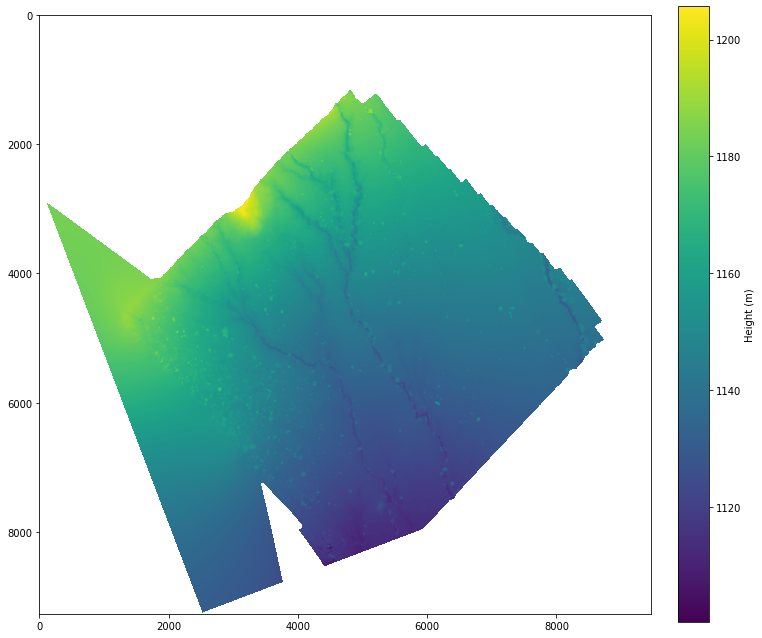

In [25]:
plt.figure(figsize=(12,16))
plot = plt.imshow(dsm)
plt.colorbar(plot, fraction=0.046, pad=0.04, label = "Height (m)")
plt.show()

In [ ]:
dsm.shape

(9266, 9469)

# Load DTM

In [26]:
def load_dtm(data_path, year, village):
  dtm = gdal.Open(os.path.join(data_path, f'rdp-{year}/{village}/DTM.tif')).ReadAsArray()
  dtm[dtm < 0] = np.nan
  print("DTM loaded")
  return dtm

In [27]:
dtm = load_dtm(DATA_PATH, year, village)
dtm.shape

DTM loaded


(9266, 9469)

## Convert DSM to be relative to the ground 

In [28]:
def convert_dsm(dsm_array, dtm_array):
  conv_dsm = dsm_array - dtm_array
  conv_dsm[conv_dsm < 0] = -1
  print("DSM converted")
  return conv_dsm

In [ ]:
dsm2 = convert_dsm(dsm, dtm)

DSM converted


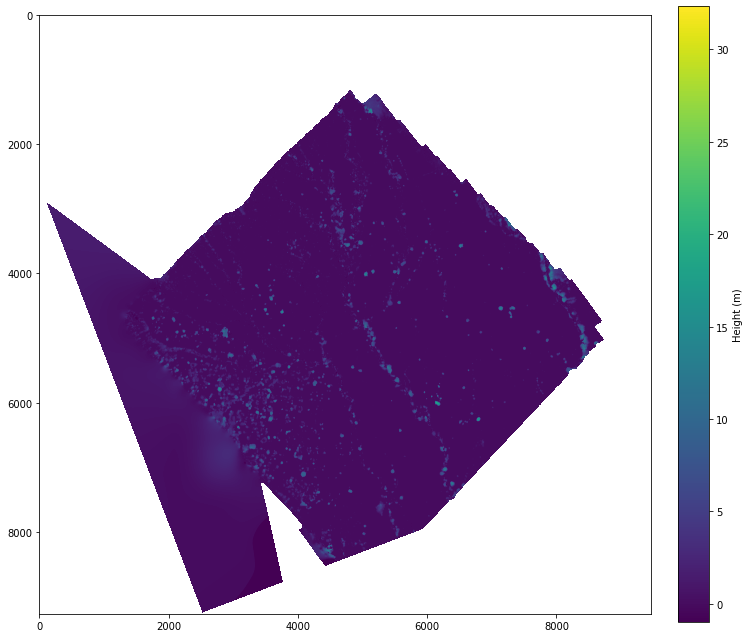

In [ ]:
plt.figure(figsize=(12,16))
plot = plt.imshow(dsm2)
plt.colorbar(plot, fraction=0.046, pad=0.04, label = "Height (m)")
plt.show()

## Save modified DSM as .tiff file

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [12]:
DSM_save_path = "/content/drive/MyDrive/AI for Trees Share/01. Data/justdiggit-drone-data/DSM/converted/"
if os.path.exists(DSM_save_path) == False:
  os.makedirs(DSM_save_path)

In [16]:
def write_tiff_file(save_path, orig_dsm, conv_dsm_array):
  # Get geotransform and projection of the original DSM
  dsm_gt = orig_dsm.GetGeoTransform()
  dsm_proj = orig_dsm.GetProjection()
  # Register Gdal driver
  driver = gdal.GetDriverByName("GTiff")
  driver.Register()
  # Create the output dataset
  out_DSM = driver.Create(save_path, xsize=conv_dsm_array.shape[1], ysize=conv_dsm_array.shape[0],
                        bands=1, eType=gdal.GDT_Float32)
  out_DSM.SetGeoTransform(dsm_gt)
  out_DSM.SetProjection(dsm_proj)
  outband = out_DSM.GetRasterBand(1)
  outband.WriteArray(conv_dsm_array)
  outband.SetNoDataValue(np.nan)
  # Clean cache and variables to dereference the objects 
  # (otherwise the write won't be successful)
  outband.FlushCache()
  outband = None
  out_DSM = None
  print(f"Saved converted DSM under {save_path}")
  return 

## Wrapping all these steps into a pipeline

In [17]:
def run_DSM_conversion_pipeline(data_path, save_path, year, village_name):
  dsm, dsm_array = load_dsm(data_path, 2019, village_name)
  dtm_array = load_dtm(data_path, 2019, village_name)
  conv_dsm_array = convert_dsm(dsm_array, dtm_array)
  write_tiff_file(os.path.join(save_path, f"{village_name}.tiff"), dsm, conv_dsm_array)

In [18]:
annotated_village_names = ["ikengwa", "kisima", "loo", "mapango", "bumila", "chaludewa"]
for village_name in annotated_village_names:
  run_DSM_conversion_pipeline(DATA_PATH, DSM_save_path, year, village_name)

DSM loaded
DTM loaded
DSM converted
Saved converted DSM under /content/drive/MyDrive/AI for Trees Share/01. Data/justdiggit-drone-data/DSM/converted/ikengwa.tiff
DSM loaded
DTM loaded
DSM converted
Saved converted DSM under /content/drive/MyDrive/AI for Trees Share/01. Data/justdiggit-drone-data/DSM/converted/kisima.tiff
DSM loaded
DTM loaded
DSM converted
Saved converted DSM under /content/drive/MyDrive/AI for Trees Share/01. Data/justdiggit-drone-data/DSM/converted/loo.tiff
DSM loaded
DTM loaded
DSM converted
Saved converted DSM under /content/drive/MyDrive/AI for Trees Share/01. Data/justdiggit-drone-data/DSM/converted/mapango.tiff
DSM loaded
DTM loaded
DSM converted
Saved converted DSM under /content/drive/MyDrive/AI for Trees Share/01. Data/justdiggit-drone-data/DSM/converted/bumila.tiff
DSM loaded
DTM loaded
DSM converted
Saved converted DSM under /content/drive/MyDrive/AI for Trees Share/01. Data/justdiggit-drone-data/DSM/converted/chaludewa.tiff
